# <span style="font-family: 'Times New Roman';"/> Statistical testing of Linear Regression models using text data</span>


<span style="font-family: 'Times New Roman' ; font-size:1.1em;"> Linear Regression has been around for a long time, although there is and ongoing discussion on which model selection method is the most suitable. $R^2$ and Negative MSE are popular metrics that are widely applied to measure the performance of Linear Regression models$^1$.</span>


<span style="font-family: 'Times New Roman' ; font-size:1.1em;">How to interpret these metrics in detail and usem them to decide which models is better for our dataset? </span>


<span style="font-family: 'Times New Roman' ; font-size:1.1em;"> The method presented in this notebook is calculation of _t-statistics_ $^1$ between series of metrics (i.e. $R^2$ and Negative MSE) calculated from results achieved by each model on different chunks of the dataset. Further testing incorporates measuring Pearson correlation between ranked coefficients from models to evaluate whether two models are correlated with each other (i.e. "understand" data in a similar way).




<span style="font-family: 'Times New Roman' ; font-size:1.1em;">References:</span>
    1. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. 2013. An Introduction to Statistical Learning. PDF. 1st ed. Springer Texts in Statistics. New York, NY: Springer. 

## <span style="font-family: 'Times New Roman';"/>Step 1: Imports 📥</span>

- <span style="font-family: 'Times New Roman' ; font-size:1.1em;">Notebook provides `sklearn` wrapper for `statsmodels` that enables to compare outputs from models from both libraries in a consistent way</span>
- <span style="font-family: 'Times New Roman' ; font-size:1.1em;">[Source of `SMWrapper()`](https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible)</span>


In [39]:
import numpy as np
import pandas as pd
import time

import sklearn
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy import stats
import statsmodels.api as sm

In [54]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors."""
    def __init__(self,
                 model_class,
                 fit_intercept=True,
                 fit_type=None,
                 L1_wt=1.0,  
                 alpha=0.0 
                ):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.fit_type = fit_type
        self.L1_wt = L1_wt
        self.alpha=alpha
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        if self.fit_type == 'regularised':
            self.results_ = self.model_.fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        else:
            self.results_ = self.model_.fit()
        
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

def build_model(X,
                y,
                regr_type='linear',
                alpha = 0,
                l1_ratio = 0,
               ):
    """For detailed description of usage of specific parameters visit:
    - https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html
    - https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
    """
    if regr_type == 'elastic': 
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=3000).fit(X, y)
    elif regr_type == 'lasso':
        model = Lasso(alpha=l1_ratio).fit(X, y) # depends on the model, in sklearn the same alpha hyperparameter is applied to either L1 (Lasso) or L2 (Ridge) 
    elif regr_type == 'linear':
        model = LinearRegression(normalize=True).fit(X, y)
    elif regr_type == 'ridge':
        model = Ridge(alpha=alpha).fit(X, y)
    elif regr_type == 'sm_elastic': 
        model = SMWrapper(sm.OLS, alpha=alpha, L1_wt=l1_ratio, fit_type='regularised')
    elif regr_type == 'sm_lasso':
        model = SMWrapper(sm.OLS, L1_wt=l1_ratio, alpha=0.0, fit_type='regularised')
    elif regr_type == 'sm_ols':
        model = SMWrapper(sm.OLS)
    elif regr_type == 'sm_ridge': 
        model = SMWrapper(sm.OLS, L1_wt=0.0, alpha=alpha, fit_type='regularised')
        
    return model


## <span style="font-family: 'Times New Roman';"/>Step 2: Prepare dataset 🗒</span>

- <span style="font-family: 'Times New Roman' ; font-size:1.1em;">[UCI News Popularity in Multiple Social Media Platforms Dataset](https://archive.ics.uci.edu/ml/datasets/News+Popularity+in+Multiple+Social+Media+Platforms#)</span>
- <span style="font-family: 'Times New Roman' ; font-size:1.1em;">Preprocessing notebook available in the repository</span>

Maximum label: 500 
Minimum label: 0 
Mean label: 65.05
Features: ['economy', 'microsoft', 'obama', 'palestine', 'ABC News', 'Bloomberg', 'Business Insider', 'CNN', 'Economic Times', 'Forbes', 'New York Times', 'Reuters', 'The Guardian', 'Washington Post', 'SentimentHeadline', 'SentimentTitle', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']


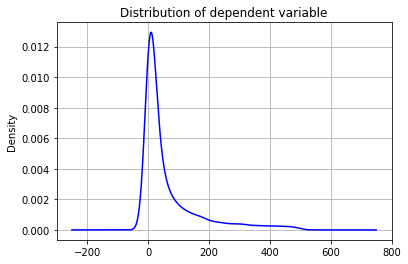

In [55]:
DATA_PATH = "data/"
FILENAME = "news_final_Facebook.csv"
Y_COL = "Facebook"

def read_dataset():
    """Overwrite method based on the dataset"""
    
    df = pd.read_csv(DATA_PATH + FILENAME)
    df = df.drop_duplicates()
    df = df.dropna()
    
    y = df[Y_COL]
    print(f"Maximum label: {y.max()} \nMinimum label: {y.min()} \nMean label: {np.round(y.mean(), 2)}")
    ax = y.plot.kde(grid=True, color='b', title='Distribution of dependent variable')    
    X = df.drop(columns=[Y_COL])
    print(f"Features: {list(X.columns)[:30]}")

    return X, y

X, y = read_dataset()

## <span style="font-family: 'Times New Roman';"/>Step 3: Generate set of results per model 🎰</span>

- <span style="font-family: 'Times New Roman' ; font-size:1.1em;"> _R-squared_ and _Negative Mean Squared Error_ will be used as evaluation metrics</span>
- <span style="font-family: 'Times New Roman' ; font-size:1.1em;">Pick set of different numbers of _k_ in K-fold validation (e.g. 6, 7, 8, 9, 10)</span>
- <span style="font-family: 'Times New Roman' ; font-size:1.1em;">Pick set of different train/test split ratios (e.g. 0.2, 0.3, 0.4, 0.5, 0.6)</span>
- <span style="font-family: 'Times New Roman' ; font-size:1.1em;">Choose hyperparameters (L1_RATIO for L1-regularisation and ALPHA for L2-regularisation)</span>

<span style="font-family: 'Times New Roman' ; font-size:1.1em;"> _Tip: it is encouraged to run full grid search i.e. test different combinations of `L1_RATIO` and `ALPHA` values_ </span>

In [58]:
# To specify TYPES, choose models from the list: 
# ['elastic', 'lasso', 'linear', 'ridge', 'sm_elastic', 'sm_lasso', 'sm_ols', 'sm_ridge'] 

TYPES = ['elastic', 'ridge']  
K_FOLDS = [6, 7, 8, 9, 10]
TEST_SIZE = [0.2, 0.3, 0.4, 0.5, 0.6]
L1_RATIO = 0.1  # L1_RATIO = 0.3 and ALPHA = 0.03 good setup
ALPHA = 0.03

def run_experiment(X, y):
    scoring = ['r2', 'neg_mean_squared_error']
    rows = []
    models = {}
    for regr_type in TYPES:
        print(f"\nTesting {regr_type}")

        for k in K_FOLDS:
            print(f"Folds: {k}")
            start = time.time()
            model = build_model(X, y, regr_type=regr_type, alpha=ALPHA, l1_ratio=L1_RATIO)
            cv = KFold(n_splits=k, random_state=1, shuffle=True)
            try:
                scores = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, return_estimator=True)
                end = time.time()
                elapsed = end - start
                rows.append([regr_type, k, scores['test_r2'].mean(), scores['test_neg_mean_squared_error'].mean(),
                            elapsed])
                models[regr_type + "_" + str(k) + "_folds"] = scores
            except ValueError as e:
                print(e)
                rows.append([regr_type, k, None, None, None])

        for t in TEST_SIZE:
            print(f"Test size: {t}")
            start = time.time()
            model = build_model(X, y, regr_type=regr_type, alpha=ALPHA, l1_ratio=L1_RATIO)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t, random_state=42)
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                end = time.time()
                elapsed = end - start
                rows.append([regr_type, t, model.score(X_test, y_test), -1*mean_squared_error(y_test, y_pred),
                            elapsed])
                models[regr_type + "_" + str(t) + "_splits"] = model
            except ValueError as e:
                print(e)
                rows.append([regr_type, k, None, None])
                
    df_results = pd.DataFrame(data=rows, columns=['model', 'split', scoring[0], scoring[1], 'time_taken'])
    return df_results
    
df_results = run_experiment(X, y)
df_results.head()


Testing elastic
Folds: 6
Folds: 7
Folds: 8
Folds: 9
Folds: 10
Test size: 0.2
Test size: 0.3
Test size: 0.4
Test size: 0.5
Test size: 0.6

Testing ridge
Folds: 6
Folds: 7
Folds: 8
Folds: 9
Folds: 10
Test size: 0.2
Test size: 0.3
Test size: 0.4
Test size: 0.5
Test size: 0.6


,model,split,r2,neg_mean_squared_error,time_taken
0,elastic,6.0,0.207443,-7926.915435,18.369363
1,elastic,7.0,0.206748,-7919.150105,19.138133
2,elastic,8.0,0.207385,-7920.144090,20.396747
3,elastic,9.0,0.204771,-7923.454051,21.956078
4,elastic,10.0,0.206341,-7918.070070,24.058607


## <span style="font-family: 'Times New Roman';"/>Step 4: Plot results 🔍</span>


### <span style="font-family: 'Times New Roman'"/>R-squared 📈 </span>

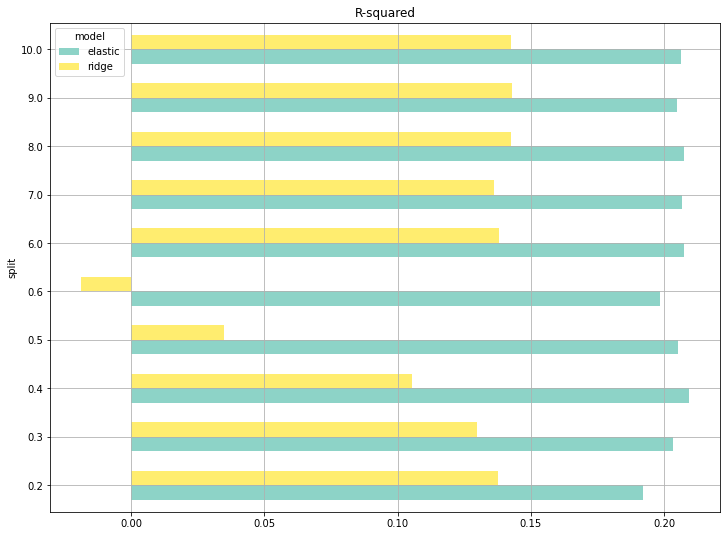

In [60]:
ax_r2 = df_results.groupby(['split', 'model']).r2.sum().unstack().plot(kind='barh', grid=True, figsize=(12, 9), title='R-squared',
                                                       colormap='Set3', width=0.6, sort_columns=True)



### <span style="font-family: 'Times New Roman';"/>Negative Mean Squared Error 📊 </span>

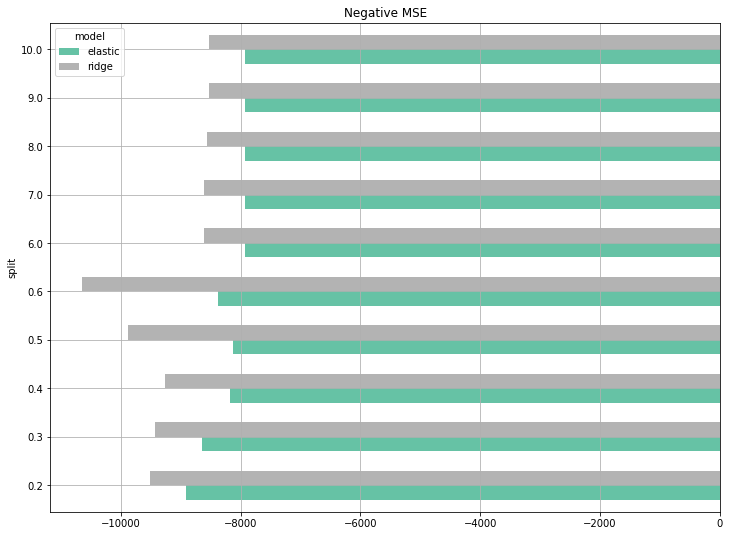

In [61]:
ax_nmse = df_results.groupby(['split', 'model']).neg_mean_squared_error.sum().unstack().plot(kind='barh', grid=True, figsize=(12, 9), title='Negative MSE',
                                                       colormap='Set2', width=0.6, sort_columns=True)

### <span style="font-family: 'Times New Roman';"/>Execution time 🕰 </span>

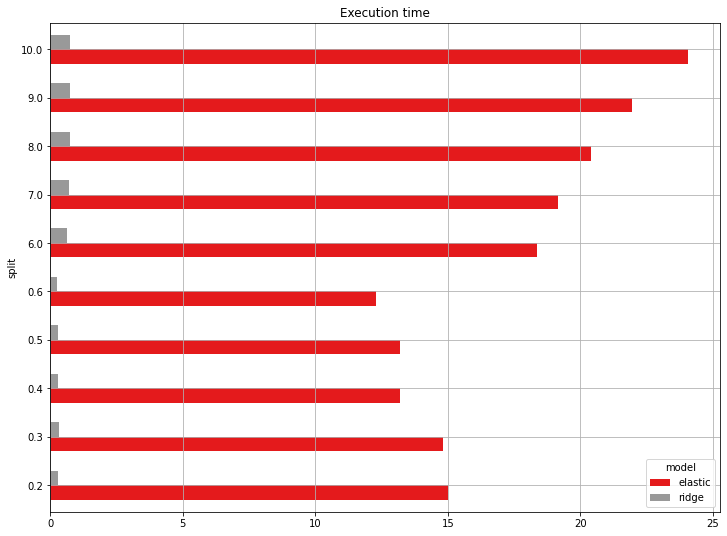

In [62]:
ax_time = df_results.groupby(['split', 'model']).time_taken.sum().unstack().plot(kind='barh', grid=True, figsize=(12, 9), title='Execution time',
                                                       colormap='Set1', width=0.6, sort_columns=True)

## <span style="font-family: 'Times New Roman';"/>Step 5: Calculate t-statistics 🤓</span>

In [63]:
SIG_THRESH = 0.05  

def t_test(df_results):
    """ Calculate t-statistics between two random variables 
    (series of results) """
    statistics = []
    for reg_1 in TYPES:

        for reg_2 in TYPES:
            if reg_1 != reg_2:

                for m in scoring:
                    ser_1 = df_results[df_results['model'] == reg_1][m]
                    ser_2 = df_results[df_results['model']  == reg_2][m]
                    t_stat, p_val = stats.ttest_ind(ser_1, ser_2)
                    statistics.append([reg_1, reg_2, m, t_stat, p_val])

    df_stats = pd.DataFrame(data=statistics, columns=['model_1', 'model_2', 'metric', 't_statistic', 'p_value'])
    df_stats['p_value'].fillna(10000000000)
    df_stats['is_significant'] = df_stats['p_value'] < SIG_THRESH
    return df_stats

df_stats = t_test(df_results)
df_stats

,model_1,model_2,metric,t_statistic,p_value,is_significant
0,elastic,ridge,r2,5.349725,0.000044,True
1,elastic,ridge,neg_mean_squared_error,3.818778,0.001258,True
2,ridge,elastic,r2,-5.349725,0.000044,True
3,ridge,elastic,neg_mean_squared_error,-3.818778,0.001258,True


## <span style="font-family: 'Times New Roman';"/>Intuition behind *t-statistics*</span>

### <span style="font-family: 'Times New Roman';"/>H0: means are equal (all models can "get out" of the data the same amount of information)</span>
### <span style="font-family: 'Times New Roman';"/>H1: at least one means is different (one model is capable of getting more/less out of the data than the other model"</span>


### <span style="font-family: 'Times New Roman';"/>*t-statistics*</span>

<span style="font-family: 'Times New Roman' ; font-size:1.1em;">The greater the magnitude of T, the greater the evidence <b>against</b> the null hypothesis. This means there is greater evidence that there is a significant difference. The closer T is to 0, the more likely there isn't a significant difference.</span>


<span style="font-family: 'Times New Roman' ; font-size:1.1em;">Negative *t-statistics* shows a reversal in the directionality of the effect being studied, it has no impact on the significance of the difference between groups of data.</span>


### <span style="font-family: 'Times New Roman';"/>*p-value*</span>

<span style="font-family: 'Times New Roman' ; font-size:1.1em;">The smaller the p-value, the more certainty there is that the null hypothesis can be rejected.</span>


### <span style="font-family: 'Times New Roman';"/>Results interpretation</span>

- <span style="font-family: 'Times New Roman' ; font-size:1.1em;">ElasticNet seems to perform better than Ridge (positive *t-statistics* in favour of Elastic Net). Positive *t-statistics* can be explained such as data is more significant in ElasticNet model (i.e. model has better capability of processing the dataset and finding the relationship between variables)</span>
- <span style="font-family: 'Times New Roman' ; font-size:1.1em;">Calculated statistics are significant (*p-value* lower than significance threshold)</span>

## <span style="font-family: 'Times New Roman';"/>Step 6: Extract raw coefficients 🔗</span>

[comment]: <> (Describe why Pearson not Spearman - literature)
[comment]: <> (Spearman correlation for for raw coefficients)
[comment]: <> (Pearson correlation for ranked data)

### <span style="font-family: 'Times New Roman';"/>Features importance</span>

<span style="font-family: 'Times New Roman'; font-size:1.1em;"/>Coefficients from the regression model are a measure of the <b>feature importance</b>. The higher coefficient of the feature, the stronger impact it has on the dependent variable. Pearson correlation can be calculated between _ranked coefficients_ that requires sorting features based on coefficients and using their ranks instead of raw coefficients.</span>


In [64]:
def extract_raw_coefficients(models):   
    coefficients = {}
    for k, v in models.items():
        coeffs = None
        n_folds = None
        if k.startswith("sm") and k.endswith("folds"):
            coeffs = np.zeros((v["estimator"][0].results_.params.shape[0]-1,))
            for i, est in enumerate(v["estimator"]):
                coeffs += np.abs(np.array(est.results_.params)[1:]) # skip intercept
            n_folds = i + 1
            coeffs /= n_folds
        elif k.startswith("sm") and k.endswith("splits"):
            coeffs = np.abs(np.array(v.results_.params[1:])) # skip intercept
        elif not k.startswith("sm") and k.endswith("folds"):
            coeffs = np.zeros((v["estimator"][0].coef_.shape[0],))
            for i, est in enumerate(v["estimator"]):
                coeffs += np.abs(np.array(est.coef_))
            n_folds = i + 1
            coeffs /= n_folds
        elif not k.startswith("sm") and k.endswith("splits"):
            coeffs = np.abs(np.array(v.coef_))

        coefficients[k] = coeffs
        
    df_raw_coeffs = pd.DataFrame(data=coefficients).set_index(X.columns)
    assert len(models.keys()) == df_raw_coeffs.shape[1]
    return df_raw_coeffs

df_raw_coeffs = extract_raw_coefficients(models)
df_raw_coeffs.head() 

,elastic_6_folds,elastic_7_folds,elastic_8_folds,elastic_9_folds,elastic_10_folds,elastic_0.2_splits,elastic_0.3_splits,elastic_0.4_splits,elastic_0.5_splits,elastic_0.6_splits,ridge_6_folds,ridge_7_folds,ridge_8_folds,ridge_9_folds,ridge_10_folds,ridge_0.2_splits,ridge_0.3_splits,ridge_0.4_splits,ridge_0.5_splits,ridge_0.6_splits
economy,9.004098,8.981078,8.962351,8.957498,8.954888,10.632088,10.998315,10.330330,9.540407,8.330492,5.732956,5.726422,5.688832,5.686657,5.699581,8.352195,10.700230,11.111133,6.213865,3.121632
microsoft,0.745138,0.716832,0.456416,0.341468,0.364578,0.191226,1.876289,1.692287,0.314525,0.159476,6.075447,5.754962,5.717219,5.618122,5.623997,7.134688,10.993898,7.129983,1.250777,0.654354
obama,12.662753,12.652830,12.673578,12.705119,12.702429,13.412291,12.408482,11.649691,11.452161,11.309876,20.099912,20.038427,20.002798,19.879895,20.010842,19.246842,19.214418,18.696335,19.119935,16.145912
palestine,3.266716,3.254983,3.247958,3.244480,3.249522,1.732184,3.287402,3.012936,2.226923,3.140134,20.442403,20.066966,20.031185,19.811360,19.935258,18.029335,19.508086,14.715185,11.655293,13.678635
ABC News,29.374982,29.434819,29.408353,29.432686,29.427793,30.592930,30.671336,31.368080,31.097275,28.932540,32.549208,32.720849,32.690712,32.765125,32.730466,35.355429,37.059812,38.807137,38.427013,33.825959


## <span style="font-family: 'Times New Roman';"/>Step 7: Measure Pearson correlation 🎰 </span>

In [67]:
FILTER_NAME = "ridge" # Name of the model to keep as rows

df_ranks = df_raw_coeffs.assign(**df_raw_coeffs.rank(axis=1, ascending=False).astype(int))
df_spearman = df_ranks.corr("spearman")

cols_to_keep = list(filter(None, [col if not FILTER_NAME in col else None for col in df_spearman.columns]))
df_spearman_filtered = df_spearman[cols_to_keep]


index_to_keep = [col if FILTER_NAME in col else None for col in df_spearman.index.values]
df_spearman_filtered = df_spearman_filtered.filter(index_to_keep, axis=0)


df_spearman_filtered.style.background_gradient(cmap='ocean_r')


,elastic_6_folds,elastic_7_folds,elastic_8_folds,elastic_9_folds,elastic_10_folds,elastic_0.2_splits,elastic_0.3_splits,elastic_0.4_splits,elastic_0.5_splits,elastic_0.6_splits
ridge_6_folds,0.313566,0.197720,0.251504,0.166363,0.170162,-0.064841,-0.085307,-0.105179,-0.104250,0.004294
ridge_7_folds,0.231085,0.347442,0.300298,0.215356,0.242638,-0.041812,-0.160749,-0.155301,-0.172573,-0.090726
ridge_8_folds,0.269210,0.236697,0.393320,0.278981,0.280743,0.016777,-0.133840,-0.168495,-0.137723,-0.143003
ridge_9_folds,0.216371,0.230746,0.285362,0.334465,0.281301,-0.005211,-0.134078,-0.103452,-0.178978,-0.192215
ridge_10_folds,0.177740,0.232807,0.282114,0.255326,0.298670,-0.014101,-0.156175,-0.129305,-0.144304,-0.193834
ridge_0.2_splits,-0.163420,-0.132603,-0.168137,-0.157846,-0.097367,0.166325,0.074867,-0.027839,-0.117841,-0.134468
ridge_0.3_splits,-0.201606,-0.195927,-0.224287,-0.164235,-0.163591,0.009545,0.202770,0.009192,-0.072468,-0.136957
ridge_0.4_splits,-0.256383,-0.206731,-0.241389,-0.187337,-0.222095,-0.080393,0.034013,0.206730,0.053462,-0.042819
ridge_0.5_splits,-0.144051,-0.200273,-0.220482,-0.202712,-0.202445,-0.162091,-0.081867,-0.020459,0.186232,0.081649
ridge_0.6_splits,-0.160538,-0.139808,-0.194821,-0.190172,-0.207440,-0.063113,-0.044117,-0.053606,0.103035,0.261957


### <span style="font-family: 'Times New Roman';"/>Results interpretation</span>

- <span style="font-family: 'Times New Roman' ; font-size:1.1em;"> Positive values that indicate positive correlation between models are observed on the diagonal (e.g. looking at first row and first column, both models in 6 folds experiment produced correlated results)</span>
- <span style="font-family: 'Times New Roman' ; font-size:1.1em;">Correlation should be measured when e.g. one model is used to produce recurring report but we want to replace it with model that performs better without the risk of producing entirely different results than so far</span>

## <span style="font-family: 'Times New Roman';"/> Thanks! </span>